In [1]:
!pip install pycocotools tqdm tidecv ultralytics --quiet

import torch
import numpy as np
torch.manual_seed(2022201)
np.random.seed(2022201)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 20.6 MB/s eta 0:00:0000:01


# (a) COCO 2017 validation set

In [2]:
from ultralytics.utils.downloads import download
from pathlib import Path

# Define dataset root directory
dir = Path("coco")

# Download validation images (5,000 images)
val_images_url = 'http://images.cocodataset.org/zips/val2017.zip'
download([val_images_url], dir / 'images')

# Download validation annotations
annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
download([annotations_url], dir / 'annotations')

# Note: zip dataset will be unziped by Kaggle automatically.

# Optional: remove zip files 
!rm coco/images/val2017.zip coco/annotations/annotations_trainval2017.zip

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 778M/778M [00:15<00:00, 52.7MB/s] 
Unzipping coco/images/val2017.zip to /kaggle/working/coco/images/val2017...: 100%|██████████| 5001/5001 [00:02<00:00, 2302.72file/s]


100%|██████████| 241M/241M [00:04<00:00, 54.8MB/s] 
Unzipping coco/annotations/annotations_trainval2017.zip to /kaggle/working/coco/annotations/annotations...: 100%|██████████| 6/6 [00:04<00:00,  1.30file/s]


# (b) Predicition using pretrained YOLOv8 model

In [3]:
from ultralytics import YOLO
import json

# Check if GPU is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained YOLOv8 model to device
model = YOLO("/kaggle/input/cv-hw1-2022201/Detection/yolov8x.pt").to(device)

# Define COCO val2017 directory
val_images_dir = Path("coco/images/val2017")

# Run inference on all validation images 
results = model(val_images_dir, device=device, save=False, verbose=False, stream=True)

# Defining index (YOLO Prediction format) to category_id (COCO format) mapping 
ground_truth_json = "coco/annotations/annotations/instances_val2017.json" # Path to the val annotations JSON file
with open(ground_truth_json) as f:
    coco_data = json.load(f)
category_id_map = {idx: category["id"] for idx,category in enumerate(coco_data["categories"])}

# Prepare results in COCO format
coco_results = []
for result in results:
    image_id = int(Path(result.path).stem)
    for box in result.boxes.data.tolist():
        x_min, y_min, x_max, y_max, score, category = box 
        # Calculating width, height
        w = x_max - x_min 
        h = y_max - y_min
        coco_results.append({
            "image_id": image_id,
            "category_id": category_id_map[category],
            "bbox": [x_min, y_min, w, h],
            "score": float(score)
        })

# Save results as a JSON file in COCO format
predictions_json = "coco_predictions.json" # Path to the predictions JSON file
with open(predictions_json, "w") as f:
    json.dump(coco_results, f)

print(f"Predictions saved to {predictions_json}")

Predictions saved to coco_predictions.json


In [26]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

predictions_json = "coco_predictions.json" # Path to the predictions JSON file
ground_truth_json = "coco/annotations/annotations/instances_val2017.json" # Path to the val annotations JSON file

# Load ground truth annotations
coco_gt = COCO(ground_truth_json)

# Load model predictions
coco_dt = coco_gt.loadRes(predictions_json)

# Run COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=13.63s).
Accumulating evaluation results...
DONE (t=2.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.616
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

# (c) TIDE statistics Computation

-- coco_predictions --

bbox AP @ 50: 61.62

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     2.37     4.86     0.57     0.13     1.59    21.65  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       5.19      29.26  



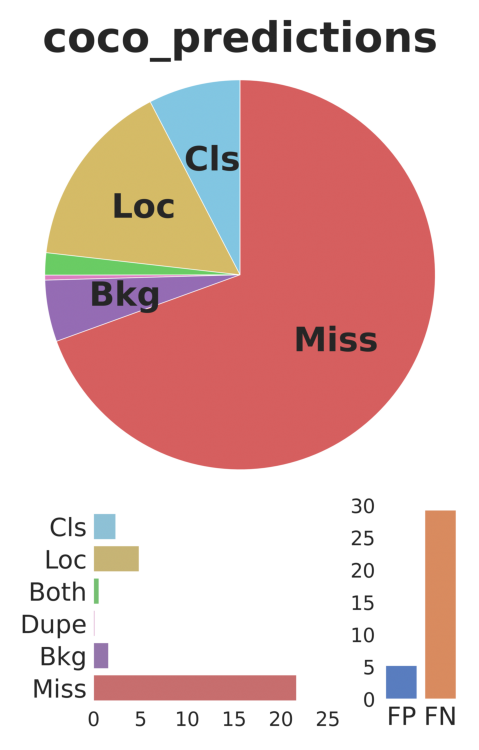

In [39]:
from tidecv import TIDE, datasets

# Function to run TIDE for a given scale
def run_tide(gt_file, pred_file, area):
    tide = TIDE()  # Initialize TIDE
    tide.evaluate(datasets.COCO(gt_file), datasets.COCOResult(pred_file), mode=TIDE.BOX)
    tide.summarize()
    tide.plot(out_dir=f"tide_plots_{area}")  # Save plots for this scale
    tide.plot() # Show in terminal

# Run TIDE for all area
run_tide(ground_truth_json, predictions_json, "all")

# (d) Expected Calibration Error (ECE) Computation

ECE is a metric to evaluate the calibration of a model. It is defined as the expected value of the absolute difference between the accuracy and the confidence of the model. The confidence of the model is the probability assigned to the predicted class. The accuracy is 1 if the prediction is correct and 0 otherwise. The ECE is computed by dividing the confidence interval [0, 1] into M equally spaced bins and computing the weighted average of the absolute difference between the accuracy and the confidence in each bin. The weights are the proportion of samples in each bin. The ECE is defined as:

\begin{equation}
ECE = \sum_{m=1}^{M} \frac{B_m}{N} \left| \text{acc}(B_m) - \text{conf}(B_m) \right|
\end{equation}

where $B_m$ is the set of samples in bin $m$, $N$ is the total number of samples, $\text{acc}(B_m)$ is the accuracy of the model in bin $m$, and $\text{conf}(B_m)$ is the confidence of the model in bin $m$. The accuracy and confidence in bin $m$ are defined as:

\begin{equation}
\text{acc}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} \mathbb{1} \left( y_i = \hat{y}_i \right)
\end{equation}

\begin{equation}
\text{conf}(B_m) = \frac{1}{|B_m|} \sum_{i \in B_m} p_i
\end{equation}

where $y_i$ is the true label of sample $i$, $\hat{y}_i$ is the predicted label of sample $i$, $p_i$ is the confidence of the model for sample $i$, and $\mathbb{1}(\cdot)$ is the indicator function.


In [40]:
def coco_to_corners(bbox):
    """Convert COCO bbox [x,y,w,h] to corners format [x1,y1,x2,y2]"""
    return np.array([
        bbox[0],
        bbox[1],
        bbox[0] + bbox[2],
        bbox[1] + bbox[3]
    ])

def ECE(confidences, accuracy, m_bins=15):
    """
    Compute Expected Calibration Error (ECE).
    
    Parameters:
    - confidences: NumPy array of model confidence scores.
    - accuracy: NumPy array of accuracy (1 if correct, 0 if incorrect).
    - m_bins: Number of bins for calibration.

    Returns:
    - ece: Expected Calibration Error.
    """
    N = len(confidences) # Total Number of samples 
    
    bin_boundaries = np.linspace(0, 1, m_bins + 1)  # Define bin edges
    bin_lowers = bin_boundaries[:-1]  # Lower bound of bins
    bin_uppers = bin_boundaries[1:]   # Upper bound of bins
    
    ece = 0.0  # Initialize ECE value
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Select samples that fall into this bin
        in_bin_mask = (bin_lower <= confidences) & (confidences < bin_upper)
        bin_size = np.sum(in_bin_mask)  # Number of samples in bin
        
        if bin_size > 0:
            # Compute average confidence & accuracy in the bin
            avg_confidence = np.mean(confidences[in_bin_mask])
            avg_accuracy = np.mean(accuracy[in_bin_mask])
            
            # Compute weighted ECE contribution
            bin_weight = bin_size / N  # Weight by bin proportion
            ece += bin_weight * abs(avg_confidence - avg_accuracy)

    return ece

def compute_iou(box1, box2):
    """
    Compute Intersection-over-Union (IoU) between two bounding boxes.
    Each box is in format [x_min, y_min, width, height].
    """
    # Convert boxes to [x_min, y_min, x_max, y_max]
    box1 = coco_to_corners(box1)
    box2 = coco_to_corners(box2)

    # Compute intersection area
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Compute union area
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

def run_ece(gt_file, pred_file, area):
    """
    Compute Expected Calibration Error (ECE) for a specific object scale.

    Parameters:
    - gt_file: Path to the ground truth annotations file (COCO format).
    - pred_file: Path to the predictions file (COCO format).
    - area: Object scale being evaluated ("all", "small", "medium", "large").

    Returns:
    - ece_score: Expected Calibration Error for the specified scale.
    """
    # Load predictions and ground truth
    with open(pred_file, "r") as f:
        predictions = json.load(f)

    with open(gt_file, "r") as f:
        gt_data = json.load(f)

    # Convert GT annotations into a dictionary
    gt_dict = {}
    for ann in gt_data["annotations"]:
        image_id = ann["image_id"]
        if image_id not in gt_dict:
            gt_dict[image_id] = []
        gt_dict[image_id].append({
            "category_id": ann["category_id"],
            "bbox": ann["bbox"]
        })

    # Extract confidence scores and correctness
    confidences = []
    correctness = []

    # Compare predictions with ground truth
    for pred in predictions:
        score = pred["score"]  # Confidence score
        category_id = pred["category_id"]  # Predicted class
        image_id = pred["image_id"]  # Image ID
        pred_bbox = pred["bbox"]  # Predicted bounding box

        is_correct = False
        if image_id in gt_dict:
            for gt in gt_dict[image_id]:
                if gt["category_id"] == category_id:
                    iou = compute_iou(pred_bbox, gt["bbox"])
                    if iou >= 0.5:  # IoU threshold
                        is_correct = True
                        break  # Match found, no need to check other GT objects

        # Store values
        confidences.append(score)
        correctness.append(1 if is_correct else 0)

    # Compute ECE
    ece_score = ECE(np.array(confidences), np.array(correctness), m_bins=15)
    print(f"Expected Calibration Error (ECE), area = {area} : {ece_score:.6f}")

In [41]:
run_ece(ground_truth_json, predictions_json, "all")

Expected Calibration Error (ECE), area = all : 0.073812


# (e) Size-based Analysis 

In [42]:
# Size thresholds as per COCO
SMALL_THRESH = 32 * 32
MEDIUM_THRESH = 96 * 96

with open(predictions_json, "r") as f:
    predictions = json.load(f)

with open(ground_truth_json, "r") as f:
    gt_data = json.load(f)

# Define function to determine object scale based on bbox area
def get_object_area(bbox):
    area = bbox[2] * bbox[3]  # width * height
    if area < SMALL_THRESH:
        return "small"
    elif SMALL_THRESH <= area < MEDIUM_THRESH:
        return "medium"
    else:
        return "large"

# --- Step 1: Filter Predictions ---
predictions_small = [pred for pred in predictions if get_object_area(pred["bbox"]) == "small"]
predictions_medium = [pred for pred in predictions if get_object_area(pred["bbox"]) == "medium"]
predictions_large = [pred for pred in predictions if get_object_area(pred["bbox"]) == "large"]

# --- Step 2: Filter Ground Truth ---
small_ids, medium_ids, large_ids = set(), set(), set()
gt_small, gt_medium, gt_large = [], [], []

for ann in gt_data["annotations"]:
    size = get_object_area(ann["bbox"])
    if size == "small":
        gt_small.append(ann)
        small_ids.add(ann["image_id"])
    elif size == "medium":
        gt_medium.append(ann)
        medium_ids.add(ann["image_id"])
    else:
        gt_large.append(ann)
        large_ids.add(ann["image_id"])

# Retain only relevant images
def filter_images(image_list, valid_ids):
    return [img for img in image_list if img["id"] in valid_ids]

gt_images_small = filter_images(gt_data["images"], small_ids)
gt_images_medium = filter_images(gt_data["images"], medium_ids)
gt_images_large = filter_images(gt_data["images"], large_ids)

# --- Step 3: Save Filtered Data ---
def save_filtered_data(data, filename):
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)

# Save Predictions
save_filtered_data(predictions_small, "coco_predictions_small.json")
save_filtered_data(predictions_medium, "coco_predictions_medium.json")
save_filtered_data(predictions_large, "coco_predictions_large.json")

# Save Ground Truth in Correct COCO Format
save_filtered_data({"images": gt_images_small, "annotations": gt_small, "categories": gt_data["categories"]}, "ground_truth_small.json")
save_filtered_data({"images": gt_images_medium, "annotations": gt_medium, "categories": gt_data["categories"]}, "ground_truth_medium.json")
save_filtered_data({"images": gt_images_large, "annotations": gt_large, "categories": gt_data["categories"]}, "ground_truth_large.json")

## Size-based TIDE computation

-- coco_predictions_small --

bbox AP @ 50: 31.06

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     3.07     2.04     0.11     0.05     3.84    37.77  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       5.81      46.36  



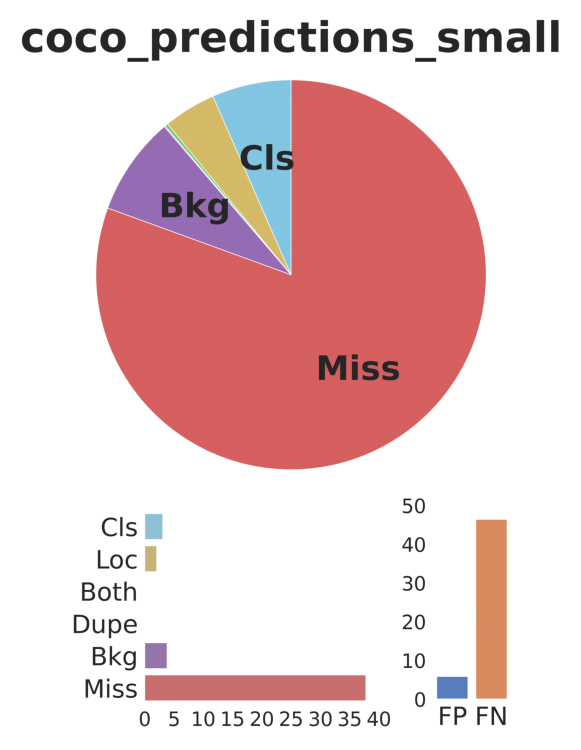

-- coco_predictions_medium --

bbox AP @ 50: 58.66

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     2.09     3.10     0.48     0.05     4.38    23.21  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       7.11      28.73  



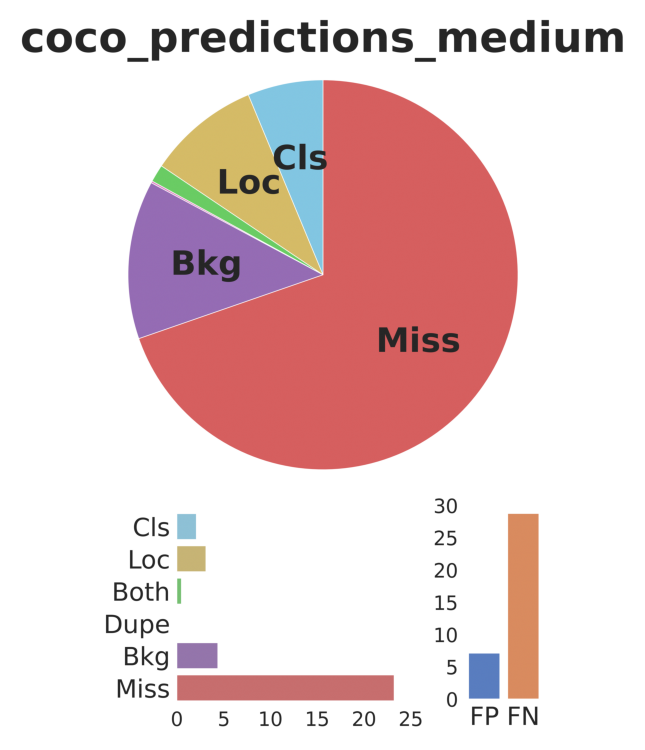

-- coco_predictions_large --

bbox AP @ 50: 75.31

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP     2.83     3.56     0.79     0.11     1.33    12.56  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       4.52      18.48  



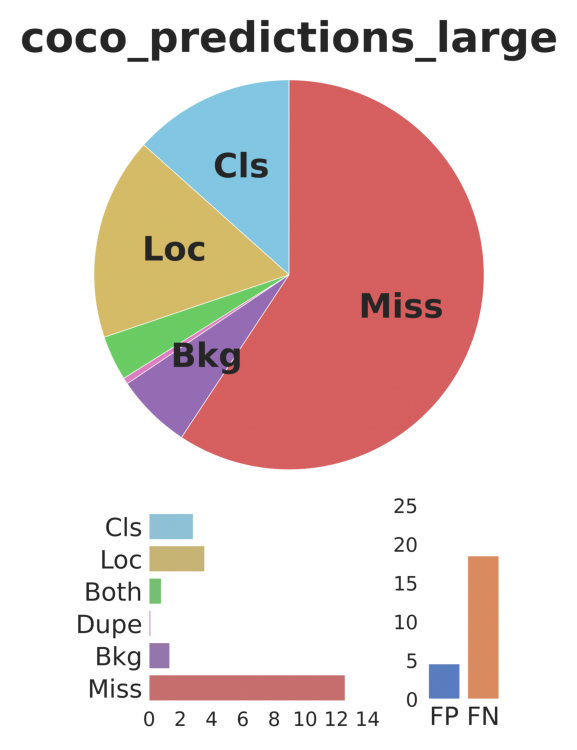

In [43]:
run_tide("ground_truth_small.json", "coco_predictions_small.json", "small")
run_tide("ground_truth_medium.json", "coco_predictions_medium.json", "medium")
run_tide("ground_truth_large.json", "coco_predictions_large.json", "large")

## Size-based ECE computation.


In [44]:
run_ece("ground_truth_small.json", "coco_predictions_small.json", "small")
run_ece("ground_truth_medium.json", "coco_predictions_medium.json", "medium")
run_ece("ground_truth_large.json", "coco_predictions_large.json", "large")

Expected Calibration Error (ECE), area = small : 0.080770
Expected Calibration Error (ECE), area = medium : 0.041552
Expected Calibration Error (ECE), area = large : 0.031818
